In [1]:
import open3d as o3d

In [2]:
import numpy as np
# import h5py
import os
import glob
import time
import subprocess
import torch
import torch.nn as nn
import MinkowskiEngine as ME
import MinkowskiEngine.MinkowskiFunctional as MF
# torch.backends.cudnn.deterministic=True

In [3]:
print(ME.__version__)

0.5.1


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(device)

cuda


## load data

In [5]:
filedir = '/home/ubuntu/Desktop/wjq/testdata/Owlii/dancer_vox11_00000001.ply'
print(filedir)

/home/ubuntu/Desktop/wjq/testdata/Owlii/dancer_vox11_00000001.ply


In [6]:
from eval import partition_point_cloud, load_sp_tensor

In [7]:
max_num = 2e6
voxel_size = 1

filedirs, nPart = partition_point_cloud(filedir, max_num)
filedir = filedirs[0]

pcd=o3d.io.read_point_cloud(filedir)
num_points = len(np.asarray(pcd.points))
print("num_points:", num_points)

start= time.time()
x = load_sp_tensor(filedir, voxel_size=voxel_size, device=device)
prefix = os.path.split(filedir)[-1].split('.')[0]
print("loading time:", round(time.time() - start, 4))

num_points: 1296379
loading time: 1.6257


## load model

In [8]:
from PCCModel import PCC
pcc = PCC(channels=8).to(device)

/home/ubuntu/anaconda3/envs/me2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/me2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/me2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anaconda3/envs/me2/lib/python3.7/site-pack

In [9]:
ckptdir = './ckpts/c8_a6_32000.pth'

In [10]:
if os.path.exists(ckptdir):
    ckpt = torch.load(ckptdir)
    pcc.encoder.load_state_dict(ckpt['encoder'])
    pcc.decoder.load_state_dict(ckpt['decoder'])
    pcc.entropy_bottleneck.load_state_dict(ckpt['entropy_bottleneck'])
    print('load from ', ckptdir)
else:
    print('load failed!')
# print("parameter number:", sum(p.numel() for p in pcc.parameters()))

load from  ./ckpts/c8_a6_32000.pth


## encode

In [11]:
import time
start = time.time()
with torch.no_grad():
    ys = pcc.encoder(x)
    y = ME.SparseTensor(ys[0].F, coordinates=ys[0].C, tensor_stride=8, device=device)
print('encoder time:', round(time.time() - start, 4), 's')
print("downsample:", x.C.shape[0], ys[-1].C.shape[0], ys[-2].C.shape[0], ys[-3].C.shape[0])

encoder time: 0.3342 s
downsample: 1296379 351099 91040 23302


In [12]:
# # calculate flops and paras
# from thop import profile
# from utils.flops import count_sparse_conv, count_sparse_deconv
# flops_e, params_e = profile(pcc.encoder, inputs=(x, ), 
#                        custom_ops={ME.MinkowskiConvolution:count_sparse_conv})
# print(flops_e/2/pow(10,9), params_e)

In [13]:
from utils.gpcc_wrapper import load_ply_data, write_ply_data, gpcc_encode, gpcc_decode

y_coords = (y.decomposed_coordinates[0]//y.tensor_stride[0]).cpu().numpy().astype('int')
print(y_coords.shape[0])
plyname = prefix+'_coords.ply'
write_ply_data(plyname, y_coords)
binname = prefix+'_coords.bin'
start = time.time()
gpcc_encode(plyname, binname, False)
print('coords encode time:', round(time.time() - start, 4))

bin_bytes = os.path.getsize(binname)
coords_bpp = 8*bin_bytes / num_points
print("coords", round(coords_bpp, 6), "bpp")

23302
coords encode time: 0.1094
coords 0.020932 bpp


In [14]:
from eval import sort_sparse_tensor
coords_sorted, feats_sorted, _ = sort_sparse_tensor(y.C, y.F)# SORT
# add coords 
y_sorted = ME.SparseTensor(feats_sorted, coords_sorted, tensor_stride=8, device=device)

strings, min_v, max_v = pcc.entropy_bottleneck.compress(y_sorted.F, device=device)
shape = y_sorted.F.shape

print("feats:", round(len(strings)*8 / num_points, 4), 'bpp')

feats: 0.2706 bpp


## decode

In [15]:
plyname_rec = prefix+'_kernel_rec.ply'
gpcc_decode(binname, plyname_rec, False)
# avs_pcc_decode(binname, plyname_rec, False)
y_coords_rec = load_ply_data(plyname_rec)
print(y_coords_rec.shape[0])

23302


In [16]:
feats_rec = pcc.entropy_bottleneck.decompress(strings, min_v, max_v, shape, device=device)
# check
feats_tilde, likelihood = pcc.entropy_bottleneck(y_sorted.F, False, device)
print(torch.max(torch.abs(feats_rec - feats_tilde)).cpu().detach().numpy() == 0)

True


In [17]:
# get feature shape
from eval import sort_xyz
coords_rec = sort_xyz(y_coords_rec)*8

In [18]:
# add batch index
coords_rec, feats_rec = ME.utils.sparse_collate([coords_rec], [feats_rec])

In [19]:
y_rec = ME.SparseTensor(feats_rec, coords_rec.int(), tensor_stride=8, device=device)

In [20]:
# check
print((y_sorted.C.cpu().detach().numpy() == y_rec.C.cpu().detach().numpy()).all())
print("Quantization Error:", (y_sorted.F - y_rec.F).abs().max().cpu().detach().numpy())

True
Quantization Error: 0.49999547


In [21]:
target_label=ys[1:]+[x]
# target_label = [len(ys[1]), len(ys[2]), len(x)]
# print(target_label)

In [22]:
start = time.time()
with torch.no_grad():
    out, out_cls, targets, keeps = pcc.decoder(y_rec, target_label, 
                                               adaptive=True, rhos=[1.0, 1.0, 1.0], training=False)

print(round(time.time()-start, 4), 's')

1.3684 s


In [23]:
# # calculate flops and paras
# from thop import profile
# from utils.flops import count_sparse_conv, count_sparse_deconv
# flops_d, params_d = profile(pcc.decoder, inputs=(y_rec, target_label, True), 
#                        custom_ops={ME.MinkowskiConvolution:count_sparse_conv, 
#                                   ME.MinkowskiConvolutionTranspose:count_sparse_deconv})
# print(flops_d/2/pow(10, 9), params_d)

In [24]:
print("downsample:", ys[0].shape[0], ys[1].shape[0], ys[2].shape[0], x.shape[0])
print("upsample:", out_cls[0].shape[0], out_cls[1].shape[0], out_cls[2].shape[0])
print("ratio:", round(out_cls[0].shape[0]/ys[1].shape[0], 2), 
              round(out_cls[1].shape[0]/ys[2].shape[0], 2), 
              round(out_cls[2].shape[0]/x.shape[0], 2))

downsample: 23302 91040 351099 1296379
upsample: 186416 728320 2808792
ratio: 2.05 2.07 2.17


## Metrics

In [25]:
eval_bpp = torch.sum(torch.log(likelihood)) / -(torch.log(torch.Tensor([2.0]).cuda())) / num_points
actual_bpp = len(strings) * 8 / num_points
print(num_points)
print('eval bpp:', round(eval_bpp.detach().cpu().numpy()[0], 3))
print('actual bpp:', round(actual_bpp, 3))
print('kerenl bpp:', round(coords_bpp, 3))
print('all bpp:', round(actual_bpp + coords_bpp, 3))

1296379
eval bpp: 0.271
actual bpp: 0.271
kerenl bpp: 0.021
all bpp: 0.292


In [26]:
crit = torch.nn.BCEWithLogitsLoss()
from utils.loss import get_metrics

losses = []
for out_cl, target in zip(out_cls, targets):
    curr_loss = crit(out_cl.F.squeeze(),
                   target.type(out_cl.F.dtype).to(device))
    losses.append(curr_loss.item())

metrics = []
for keep, target in zip(keeps, targets):
    curr_metric = get_metrics(keep, target.bool())
    metrics.append(curr_metric)
    
print(metrics)

[[0.9993, 0.9993, 0.9986], [0.9758, 0.976, 0.9529], [0.9187, 0.9264, 0.8562]]


/home/ubuntu/Desktop/wjq/sparseConv/PCGCv2/utils/loss.py:16: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370128159/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  TP = (keep * target).nonzero().shape[0]


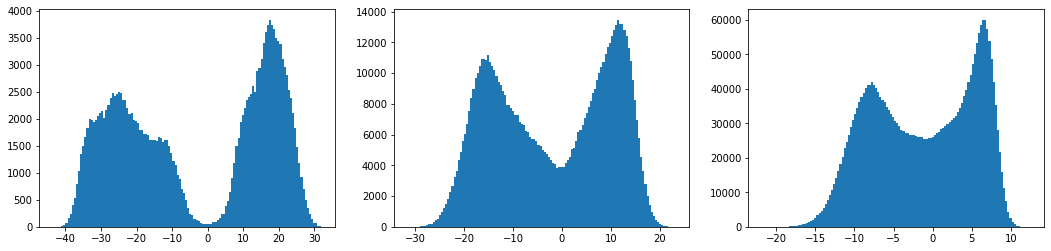

In [27]:
import matplotlib.pylab  as plt

# plt.figure("1")
# plt.title('CPU')
plt.figure(figsize=(18, 4))
plt.subplot(131)
n, bins, patches = plt.hist(out_cls[0].F.cpu().detach().numpy().flatten(), bins=128)
# plt.show()
# plt.figure("2")
plt.subplot(132)
n, bins, patches = plt.hist(out_cls[1].F.cpu().detach().numpy().flatten(), bins=128)
# plt.show()
# plt.figure("3")
plt.subplot(133)
n, bins, patches = plt.hist(out_cls[2].F.cpu().detach().numpy().flatten(), bins=128)
plt.show()


In [30]:
# ori_pcd = o3d.geometry.PointCloud()
# # From numpy to Open3D
# ori_pcd.points = o3d.utility.Vector3dVector(x.decomposed_coordinates[0])
# # ori_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=20, max_nn=20))

# orifile = prefix+'_ori.ply'
# os.system('rm '+ orifile)
# o3d.io.write_point_cloud(orifile, ori_pcd, write_ascii=True)
start = time.time()
rec_pcd = o3d.geometry.PointCloud()
# From numpy to Open3D
rec_pcd.points = o3d.utility.Vector3dVector(out.decomposed_coordinates[0].cpu())
if voxel_size > 1:
    rec_pcd.points = o3d.utility.Vector3dVector(out.decomposed_coordinates[0]*voxel_size)
# ori_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=20, max_nn=20))
recfile = prefix+'_rec.ply'
os.system('rm '+ recfile)
o3d.io.write_point_cloud(recfile, rec_pcd, write_ascii=True)
print("writing time:", round(time.time() - start), 2)

writing time: 6 2


In [31]:
import subprocess
resolution = 1024

orifile = filedir
subp=subprocess.Popen("utils/pc_error_d " +
                      ' -a '+orifile+ 
                      ' -b '+recfile+ 
#                       ' -n '+orifile+
                      ' --hausdorff=1 '+ 
                      ' --resolution='+str(resolution-1), 
                      shell=True, stdout=subprocess.PIPE)
c=subp.stdout.readline()
while c:
    print(c)
    c=subp.stdout.readline()
print(subp.returncode)

b'PCC quality measurement software, version 0.13.4\n'
b'\n'
b'infile1:        longdress_vox10_1300_part0.ply\n'
b'infile2:        longdress_vox10_1300_part0_rec.ply\n'
b'normal1:        \n'
b'singlePass:     0\n'
b'hausdorff:      1\n'
b'color:          0\n'
b'lidar:          0\n'
b'resolution:     1023\n'
b'dropDuplicates: 2\n'
b'neighborsProc:  1\n'
b'averageNormals: 1\n'
b'nbThreads:      1\n'
b'\n'
b'Verifying if the data is loaded correctly.. The last point is: 256 902 320\n'
b'Reading file 1 done.\n'
b'Verifying if the data is loaded correctly.. The last point is: 208 681 368\n'
b'Reading file 2 done.\n'
b'Imported intrinsic resoluiton: 1023\n'
b'Peak distance for PSNR: 1023\n'
b'Point cloud sizes for org version, dec version, and the scaling ratio: 857966, 857966, 1\n'
b'Normals prepared.\n'
b'\n'
b'1. Use infile1 (A) as reference, loop over A, use normals on B. (A->B).\n'
b'   mse1      (p2point): 0.115044\n'
b'   mse1,PSNR (p2point): 74.3601\n'
b'   h.       1(p2point): 34\n'
